# Install dependenices

In [1]:
!pip install accelerate
!pip install scikit-learn
!pip install -q tqdm
!pip install -q scikit-learn 
!pip install -q pandas
!pip install -q matplotlib 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Hyperparameters

In [2]:
import os
file_id = '1w3IQMK3PmXH-Bq6Lt_P8wxGPvr5olrZT'
destination = 'pfam.zip'
n_families_of_interest = 50 # 3000
data_dirpath = "pfam"
os.makedirs("models", exist_ok=True)
vocab_size = 32
max_aminoacid_len = 512
batch_size = 32

In [3]:
import os
import gc
import tqdm
import json
import zipfile
import requests
import numpy as np
import pandas as pd
from functools import partial 
from collections import Counter
import matplotlib.pyplot as plt
from collections import Counter


import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Utils

In [4]:
def format_size(value):
  if value >= 1024**3:
    return f"{round(value / 1024**3 , 3)} GB"
  elif value >= 1024**2:
    return f"{round(value / 1024**2 , 3)} MB"
  elif value >= 1024:
    return f"{round(value / 1024 , 3)} KB"
  return f"{value} B"

# Code taken from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    params = { 'id' : id, 'confirm' : 1 }
    response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    pb = tqdm.tqdm(response.iter_content(CHUNK_SIZE))
    b_total = 0
    with open(destination, "wb") as f:
        for i,chunk in enumerate(pb):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                b_total += len(chunk)

                if i % 1000 == 0:
                  pb.set_description(f"written : {format_size(b_total)}")
                i += 1
    print("\n")
    print(f"saved all the data to {destination}. total size : {format_size(os.stat(destination).st_size)}")

# Download Dataset

In [5]:
download_file_from_google_drive(file_id, destination)
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(".")
!mv random_split pfam

written : 468.781 MB: : 15780it [00:04, 3452.97it/s]




saved all the data to pfam.zip. total size : 493.095 MB


In [6]:
data_dirpath = "pfam"
print('Available dataset partitions: ', os.listdir(data_dirpath))

Available dataset partitions:  ['dev', 'train', 'test', 'random_split']


# Create a raw dataset

In [7]:
def read_all_shards(partition='dev', data_dir = data_dirpath):
    shards = []
    for fn in os.listdir(os.path.join(data_dir, partition)):
        with open(os.path.join(data_dir, partition, fn)) as f:
            shards.append(pd.read_csv(f, index_col=None))
    
    return pd.concat(shards)

def read_all_data_initial():
  global train, test, dev, all_train_ds_size, all_test_ds_size, all_dev_ds_size

  test = read_all_shards('test')
  dev = read_all_shards('dev')
  train = read_all_shards('train')

  partitions = {'test': test, 'dev': dev, 'train': train}
  for name, df in partitions.items():
      print('Dataset partition "%s" has %d sequences' % (name, len(df)))

  all_train_ds_size = len(train)
  all_test_ds_size = len(test)
  all_dev_ds_size = len(dev)

  train.reset_index(inplace=True, drop=True)
  dev.reset_index(inplace=True, drop=True)
  test.reset_index(inplace=True, drop=True)

read_all_data_initial()

Dataset partition "test" has 126171 sequences
Dataset partition "dev" has 126171 sequences
Dataset partition "train" has 1086741 sequences


# Inspect the data

how many labels : 17929


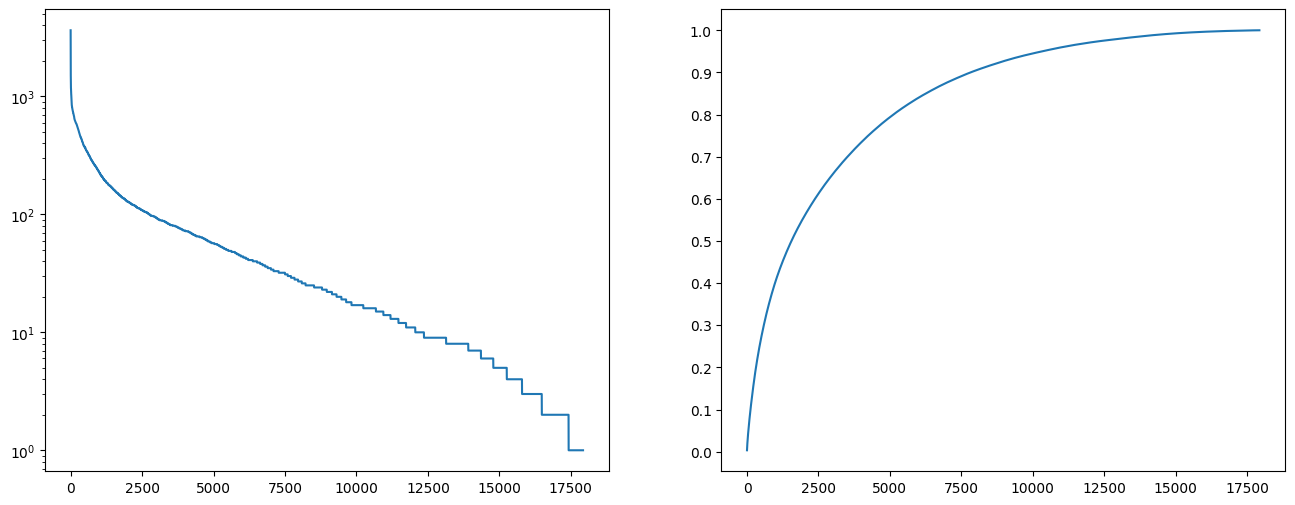

In [8]:
def plot_counts(data):

    counter = Counter(data['family_accession'])
    print(f"how many labels : {len(counter)}")
    
    datasetSize = len(data)
    xs = []
    x_labels = []
    ys = []

    t = 0
    cumulative = []

    for i,(x, y) in  enumerate(counter.most_common()):
        xs.append(i)
        x_labels.append(x)
        ys.append(y)
        t += y / datasetSize
        cumulative.append(t)

    plt.figure(figsize=(16 ,6))
    plt.subplot(1, 2, 1)
    plt.plot(xs, ys)
    plt.yscale("log")

    plt.subplot(1, 2, 2)
    plt.plot(xs, cumulative)
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
    plt.show()
    return cumulative

cumulative = plot_counts(train)

In [9]:
print(f"{n_families_of_interest} classes is {100 * round( cumulative[n_families_of_interest-1],3)} portion of training data")

50 classes is 5.1 portion of training data


# preprocess dataset

how many labels : 50


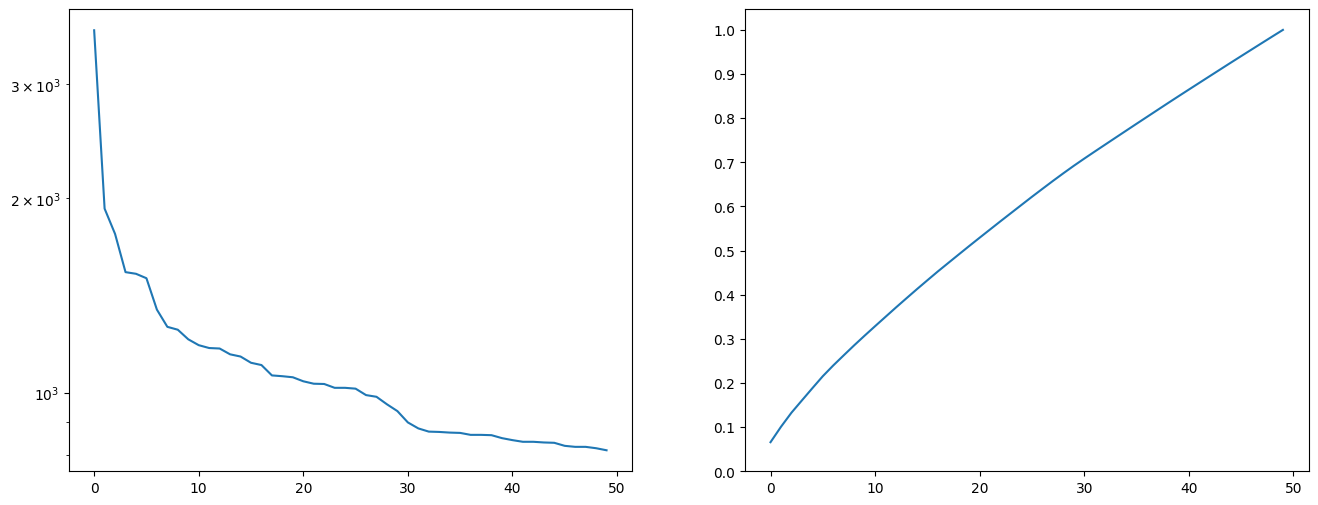

In [10]:
familiesOfInterest = train.family_accession.value_counts()[:n_families_of_interest]

mask = train.family_accession.isin(familiesOfInterest.index.values)
train = train.loc[mask,:]
mask = train["sequence"].str.len() <= max_aminoacid_len
train = train.loc[mask, :]

mask = dev.family_accession.isin(familiesOfInterest.index.values)
dev = dev.loc[mask,:]
mask = dev["sequence"].str.len() <= max_aminoacid_len
dev = dev.loc[mask,:]

mask = test.family_accession.isin(familiesOfInterest.index.values)
test = test.loc[mask,:]
mask = test["sequence"].str.len() <= max_aminoacid_len
test = test.loc[mask,:]

cumulative_split = plot_counts(train)

In [11]:
train_seq = train['sequence']
dev_seq = dev['sequence']
test_seq = test['sequence']
train_sentences = train_seq.apply(lambda seq: " ".join([aa for aa in seq]))
validation_sentences = dev_seq.apply(lambda seq: " ".join([aa for aa in seq]))
test_sentences = test_seq.apply(lambda seq: " ".join([aa for aa in seq]))

train_labels = train['family_accession'].apply(lambda x: x.split('.')[0])
validation_labels = dev['family_accession'].apply(lambda x: x.split('.')[0])
test_labels = test['family_accession'].apply(lambda x: x.split('.')[0])

In [12]:
train_sentences

10                   S L K F L N F A Q N E F N G S I P E S V
37         K R V I D I V F S I I G I V V L S P L M L A I ...
62         L G Y W P V L A G R V V A G D Q R G R Q L G F ...
103        S G A A I A A L F A G M G S A K G T S I A G Q ...
116        F V L G L V A G S L S F G G A Y T A I P F V Q ...
                                 ...                        
1086685    Y D I I A K K R D G L A L S E E E I R F F V S ...
1086688    R I Y L A S R S P R R A E L L H Q I G V A F V ...
1086708    R Q V L A R L T G G D D L A R G Q A A W A M D ...
1086729    I V T S V R K I N E Y I G I E I P A E R I I N ...
1086740    L S T E H D T L E K Q L I E S F D T R V A A R ...
Name: sequence, Length: 55216, dtype: object

In [13]:
from tqdm import tqdm 
 
class Tokenizer(object):
    def __init__(self, vocab_size, padding=512):
        self.idx_to_token = {0: '<pad>', 1:'<s>', 2:'</s>', 3: '<unk>'}
        self.token_to_idx = {k:j for j,k in self.idx_to_token.items()} 
        self.max_size = vocab_size
        self.padding = padding + 2
    
    def __len__(self):
        return len(self.token_to_idx)

    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]
    
    def build_vocabulary(self, sentences):
        idx = 4
        frequencies = {}
   
        for sentence in tqdm(sentences):
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1
                    
        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items()} 
        
        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk
            
        #create vocab
        for word in frequencies.keys():
            self.token_to_idx[word] = idx
            self.idx_to_token[idx] = word
            idx+=1
            
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = [self.token_to_idx["<s>"]]
        for token in tokenized_text:
            if token in self.token_to_idx.keys():
                numericalized_text.append(self.token_to_idx[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.token_to_idx['<unk>'])
        
        numericalized_text.append(self.token_to_idx['</s>'])
        if self.padding != -1:
          numericalized_text = numericalized_text + [self.token_to_idx["<pad>"]] * (self.padding - len(numericalized_text))

        return np.array(numericalized_text)


In [14]:
%%time
tokenizer = Tokenizer(vocab_size)
tokenizer.build_vocabulary(train_sentences)

100%|██████████| 55216/55216 [00:02<00:00, 25168.53it/s]

CPU times: user 2.2 s, sys: 15 ms, total: 2.22 s
Wall time: 2.2 s


In [15]:
%%time
train_sentences = train_sentences.apply(tokenizer.numericalize)
validation_sentences = validation_sentences.apply(tokenizer.numericalize)
test_sentences = test_sentences.apply(tokenizer.numericalize)

CPU times: user 4.97 s, sys: 98.5 ms, total: 5.07 s
Wall time: 5.05 s


In [16]:
train_sentences = train_sentences.values
validation_sentences = validation_sentences.values
test_sentences = test_sentences.values

In [17]:
print(Counter([len(v) for v in train_sentences]))
print(Counter([len(v) for v in validation_sentences]))
print(Counter([len(v) for v in test_sentences]))

Counter({514: 55216})
Counter({514: 6875})
Counter({514: 6875})


In [18]:
keys = Counter(train_labels.values).keys()
family_id_to_val = {k : v for v, k in enumerate(keys)}

train_labels = train_labels.map(family_id_to_val).values
validation_labels = validation_labels.map(family_id_to_val).values
test_labels = test_labels.map(family_id_to_val).values

# Pytorch dataset

In [47]:
class Aminoacid_dataset_train(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(train_sentences)

    def __getitem__(self, index):
        return torch.tensor(train_sentences[index]), torch.tensor(train_labels[index]) 

class Aminoacid_dataset_val(Dataset):
    def __init__(self):
      pass

    def __len__(self):
        return len(validation_sentences)

    def __getitem__(self, index):
        return torch.tensor(validation_sentences[index]), torch.tensor(validation_labels[index]) 


train_dataset = Aminoacid_dataset_train()
val_dataset = Aminoacid_dataset_val()

In [48]:
train_dl = DataLoader(train_dataset, batch_size=batch_size)
val_dl = DataLoader(val_dataset, batch_size=batch_size)

In [66]:
import torch.nn as nn 
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    
class residualBlock(nn.Module):
    def __init__(self, filters, dilation_rate=1):
        super(residualBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(filters)
        self.activ1 = nn.ReLU()
        self.conv1 = nn.Conv1d(filters, filters, kernel_size=3, dilation=dilation_rate, padding="same")
        
        self.bn2 = nn.BatchNorm1d(filters)
        self.activ2 = nn.ReLU()
        self.conv2 = nn.Conv1d(filters, filters, 1, padding="same")
        
    def forward(self, x):
        
        fwd = self.bn1(x)
        #print(fwd.shape)
        fwd = self.activ1(fwd)
        #print(fwd.shape)
        fwd = self.conv1(fwd)
        #print(fwd.shape)
        fwd = self.bn2(fwd)
        #print(fwd.shape)
        fwd = self.activ2(fwd)
        #print(fwd.shape)
        fwd = self.conv2(fwd)
        #print(fwd.shape)
        return x + fwd
        

class ProtCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ProtCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size)
        self.initial_conv = nn.Conv1d(input_size, 64, 8, padding="same")
        self.res1 = residualBlock(64, 1)
        self.res2 = residualBlock(64, 2)
        self.conv2 = nn.Conv1d(vocab_size, 64, 3, padding="same")
        self.res3 = residualBlock(64, 1)
        self.res4 = residualBlock(64, 2)
        
        self.conv3  = nn.Conv2d(1, 32, 4, padding="same")
        self.activ3 = nn.ReLU()
        self.conv4  = nn.Conv2d(32, 8, 8, padding="same")
        self.activ4 = nn.ReLU()

        self.pool = nn.MaxPool2d(64)
        self.logits = nn.Linear(8, num_classes)
        self.head = nn.Softmax()
    
    def forward(self, x):
        x = self.embedding(x)
        #x = x.permute(0, 2, 1)
        #print(x.shape)
        #raise
        x = self.initial_conv(x)
        #print(x.shape)
        x = self.res1(x)
        #print(x.shape)
        x = self.res2(x)
        #print(x.shape)
        x = x.permute(0, 2, 1)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.res3(x)
        #print(x.shape)
        x = self.res4(x)
        #print(x.shape)
        x = x.reshape(-1, 1, 64, 64)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.activ3(x)
        #print(x.shape)
        x = self.conv4(x)
        #print(x.shape)
        x = self.activ4(x)
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = x.reshape(-1, 8)
        #print(x.shape)
        return self.logits(x)
    
model = ProtCNN(514, n_families_of_interest)
model = model.to(device)

y = model(torch.zeros((1, 514)).long().to(device))

In [92]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dil, filters, ks=3):
        super(ResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels, filters, ks, padding="same", dilation=dil)
        
        self.bn2 = nn.BatchNorm1d(filters)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv1d(filters, filters, ks, padding="same")
        
    def forward(self, x):
        shortcut = x
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv1(x)
        
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv2(x)
        
        x += shortcut
        return x


class ProtCNN(nn.Module):
    def __init__(self, numclass, inp_size, vocab_size, residuals_ks=3, residuals_filters=64):
        super(ProtCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, vocab_size, padding_idx=None)
        self.embedding.weight.data.copy_(torch.eye(vocab_size))
        self.embedding.weight.requires_grad = False
        self.conv1 = nn.Conv1d(inp_size, 64, 8, padding="same")
        
        self.res_block1 = ResidualBlock(64, 1, residuals_filters, ks=residuals_ks)
        self.res_block2 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks)
        
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        
        self.res_block3 = ResidualBlock(64, 1, residuals_filters, ks=residuals_ks)
        self.res_block4 = ResidualBlock(residuals_filters, 2, residuals_filters, ks=residuals_ks)
        
        self.conv3 = nn.Conv2d(1, 32, (4, 4), padding="same")
        self.conv4 = nn.Conv2d(32, 8, (8, 8), padding="same")
        self.maxpool = nn.MaxPool2d((64, 64))
        self.fc = nn.Linear(8, numclass + 1)

    def forward(self, x):
        x = self.embedding(x)
        # x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x.permute(0, 2, 1)
        x = self.conv2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = x.unsqueeze(1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = F.softmax(x, dim=1)
        return x

model = ProtCNN(n_families_of_interest, 514, 32)
model = model.to(device)

y = model(torch.zeros((1, 514)).long().to(device))

In [ ]:
import torch
import torch.nn.functional as F
from accelerate import Accelerator

accelerator = Accelerator()
device = accelerator.device

optimizer = torch.optim.Adam(model.parameters())
model, optimizer, data = accelerator.prepare(model, optimizer, train_dl)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-3, cycle_momentum=False, 
#                                              gamma = 0.95, step_size_up = len(train_dl))


report_every = 100


for epoch in range(4):
  print("-"*64)
  pb = tqdm(train_dl)
  model.train()
  classified_correctly = 0
  len_so_far = 0
  for i, (source, targets) in enumerate(pb):
    source = source.to(device)
    targets = targets.to(device)
    
    optimizer.zero_grad()
    output = model(source)
    loss = F.cross_entropy(output, targets)
    pred = torch.argmax(output, dim=1)
    classified_correctly += torch.sum(pred == targets).item()
    len_so_far += targets.shape[0]

    accelerator.backward(loss)
    optimizer.step()

    if i % report_every == 0:
      pb.set_description(f"Loss : {round(loss.item(), 3)}, Accuracy : {round(classified_correctly / len_so_far, 4)}")

  pb = tqdm(val_dl)
  model.eval()
  classified_correctly = 0
  for i, (source, targets) in enumerate(pb):
    source = source.to(device)
    targets = targets.to(device)
    output = model(source)
    pred = torch.argmax(output, dim=1)
    classified_correctly += torch.sum(pred == targets).item()
    #pb.set_description(f"Loss : {round(loss.item(), 3)}")

  print(f"\nTotal accuracy for epoch {epoch} was {classified_correctly / len(val_dataset)}")
  optimizer.zero_grad()

----------------------------------------------------------------


100%|██████████| 215/215 [00:01<00:00, 198.01it/s]



Total accuracy for epoch 0 was 0.8641454545454545
----------------------------------------------------------------


Loss : 0.197, Accuracy : 0.9164:  97%|█████████▋| 1676/1726 [00:48<00:01, 34.61it/s]